# Assess Solvation Energies
Compare the CP2K solvation energies to those from Gaussian, which uses a different implicit solvation model.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kendalltau
from ase import units
from foundry import Foundry
from ase import units 
import pandas as pd

/lus/grand/projects/CSC249ADCD08/ExaMol/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load in the Baseline and CP2K results
The baseline is our QM9-based dataset and the CP2K is stored on disk

In [2]:
client = Foundry(force_login=True)
client.load('10.18126/jos5-wj65', globus=False)
baseline = pd.concat(client.load_data()['train'], axis=1)

In [3]:
baseline.rename(columns={'smiles_1': 'smiles'}, inplace=True)

Load the CP2K, which are stored per-calculation. We'll need to compute IE ourselves

In [4]:
cp2k_solvent = pd.read_json('solvation.json', lines=True).drop(columns=['result'])
print(f'Loaded {len(cp2k_solvent)} calculations of {len(set(cp2k_solvent.filename))} molecules')

Loaded 8213 calculations of 2862 molecules


In [5]:
cp2k_vacuum = pd.read_json('output.json', lines=True).drop(columns=['result'])
print(f'Loaded {len(cp2k_vacuum)} calculations of {len(set(cp2k_vacuum.filename))} molecules')

Loaded 14397 calculations of 3027 molecules


Merge them 

In [6]:
cp2k_data = cp2k_solvent.merge(cp2k_vacuum, on=['config_name', 'charge', 'filename', 'smiles'], suffixes=['_solvent', '_vacuum'])

In [7]:
cp2k_data['G_solv'] = (cp2k_data['energy_solvent'] - cp2k_data['energy_vacuum']) * units.mol / units.kcal

## Compare to PCM
Compare each of configurations we've run with CP2K

In [8]:
total_configs = len(set(cp2k_data.config_name))

cp2k_blyp_dzvp 1.2875475014245474


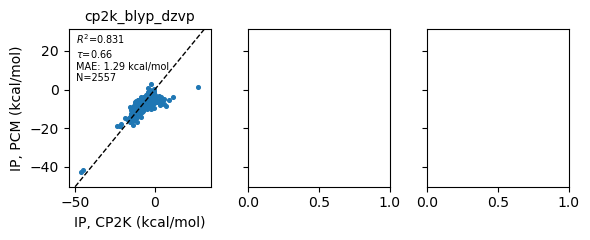

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6, 2.5))

for ax, (gid, group) in zip(axs, cp2k_data.query('charge==0').groupby('config_name')):
    ax.set_title(gid, fontsize=10)
    
    # Plot the data
    merged = group.merge(baseline, on=['smiles'])
    r2 = pearsonr(merged['G_solv'], merged['sol_acn'])
    tau = kendalltau(merged['G_solv'], merged['sol_acn'])
    offset = (merged['G_solv'] - merged['sol_acn']).mean()
    mae = ((merged['G_solv'] - merged['sol_acn']) - offset).abs().mean()
    print(gid, mae)
    ax.scatter(merged['G_solv'], merged['sol_acn'], s=7)
    ax.text(0.05, 0.98, f'$R^2$={r2[0]:.3f}\n$\\tau$={tau[0]:.2f}\nMAE: {mae :.2f} kcal/mol\nN={len(merged)}', 
           transform=ax.transAxes, va='top', fontsize=7)
    
    # Plot y=x
    #ax.set_xlim(4, 16)
    ax.set_ylim(ax.get_xlim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    ax.set_xlabel('IP, CP2K (kcal/mol)')

axs[0].set_ylabel('IP, PCM (kcal/mol)')
fig.tight_layout()